In [1]:
#https://towardsdatascience.com/feature-selection-using-python-for-classification-problem-b5f00a1c7028#:~:text=Univariate%20feature%20selection%20works%20by,analysis%20of%20variance%20(ANOVA).&text=That%20is%20why%20it%20is%20called%20'univariate'.
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

In [ ]:
# VARIANCE THRESHOLD to remove features

In [2]:
from sklearn.feature_selection import VarianceThreshold
X = [[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]
X

[[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]

In [3]:
# remove all features that are either one or zero (on or off) in more than 80% of the samples
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)

array([[0, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [1, 1]])

In [4]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X, y = load_iris(return_X_y=True)
X.shape

(150, 4)

In [ ]:
# SELECT K BEST and chi squared to remove features

In [5]:
# remove features based on chi squared scores
# Recall that the chi-square test measures dependence between stochastic variables, so using this function “weeds out” the features that are the most likely to be independent of class and therefore irrelevant for classification.
X_new = SelectKBest(chi2, k=2).fit_transform(X, y)
X_new.shape

(150, 2)

In [6]:
# UNIVARIATE FEATURE SELECTION and f scores from ANOVA to remove features (looks at one feature at a time and its relationship to output)
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif

In [8]:
# Import some data to play with

# The iris dataset
X, y = load_iris(return_X_y=True)

# Some noisy data not correlated
E = np.random.RandomState(42).uniform(0, 0.1, size=(X.shape[0], 20))

# Add the noisy data to the informative features
X = np.hstack((X, E))

# Split dataset to select feature and evaluate the classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

plt.figure(1)
plt.clf()

X_indices = np.arange(X.shape[-1])


<Figure size 432x288 with 0 Axes>

Classification accuracy without selecting features: 0.789
Classification accuracy after univariate feature selection: 0.868


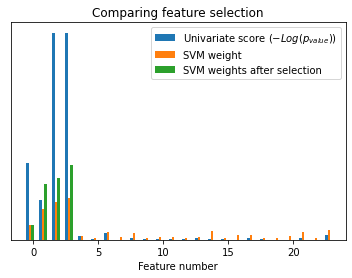

In [9]:
# #############################################################################
# Univariate feature selection with F-test for feature scoring
# We use the default selection function to select the four
# most significant features
selector = SelectKBest(f_classif, k=4)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.bar(
    X_indices - 0.45, scores, width=0.2, label=r"Univariate score ($-Log(p_{value})$)"
)

# #############################################################################
# Compare to the weights of an SVM
clf = make_pipeline(MinMaxScaler(), LinearSVC())
clf.fit(X_train, y_train)
print(
    "Classification accuracy without selecting features: {:.3f}".format(
        clf.score(X_test, y_test)
    )
)

svm_weights = np.abs(clf[-1].coef_).sum(axis=0)
svm_weights /= svm_weights.sum()

plt.bar(X_indices - 0.25, svm_weights, width=0.2, label="SVM weight")

#uses f score from ANOVAS to choose best 4 features 
clf_selected = make_pipeline(SelectKBest(f_classif, k=4), MinMaxScaler(), LinearSVC())
clf_selected.fit(X_train, y_train)
print(
    "Classification accuracy after univariate feature selection: {:.3f}".format(
        clf_selected.score(X_test, y_test)
    )
)

svm_weights_selected = np.abs(clf_selected[-1].coef_).sum(axis=0)
svm_weights_selected /= svm_weights_selected.sum()

plt.bar(
    X_indices[selector.get_support()] - 0.05,
    svm_weights_selected,
    width=0.2,
    label="SVM weights after selection",
)


plt.title("Comparing feature selection")
plt.xlabel("Feature number")
plt.yticks(())
plt.axis("tight")
plt.legend(loc="upper right")
plt.show()

In [10]:
# RECURSIVE FEATURE SELECTION w/ random forest model
# Compared to univariate feature selection, model-based feature selection consider all feature at once, thus can capture interactions. 
model_tree = RandomForestClassifier(random_state=100, n_estimators=50) #fit model
sel_rfe_tree = RFE(estimator=model_tree, n_features_to_select=4, step=1) #define recursive elimination
X_train_rfe_tree = sel_rfe_tree.fit_transform(X_train, y_train) #fit model and transform w/ new features
print(sel_rfe_tree.get_support()) #output shows which features are selected 

[ True False  True  True False False False False False False False False
 False False False False False False False False False False False  True]


In [11]:
# SELECT FROM MODEL prunes features based on threshold
from sklearn.feature_selection import SelectFromModel
model_tree = RandomForestClassifier(random_state=100, n_estimators=50)
model_tree.fit(X_train, y_train)
print(model_tree.feature_importances_)
sel_model_tree = SelectFromModel(estimator=model_tree, prefit=True, threshold='mean')  
      # since we already fit the data, we specify prefit option here
      # Features whose importance is greater or equal to the threshold are kept while the others are discarded.
X_train_sfm_tree = sel_model_tree.transform(X_train)
print(sel_model_tree.get_support()) #print which features were selected 

#create new model with paired down features
model_tree_2 = RandomForestClassifier(random_state=100, n_estimators=50)
model_tree_2.fit(X_train_sfm_tree, y_train)

[0.12140574 0.05807571 0.27409467 0.21186512 0.0109462  0.00724534
 0.03065725 0.01678772 0.02334842 0.01800926 0.00732635 0.0118654
 0.01072565 0.02077006 0.01442141 0.02742221 0.01559849 0.0160765
 0.01209733 0.01642609 0.01415509 0.02777367 0.01103351 0.02187282]
[ True  True  True  True False False False False False False False False
 False False False False False False False False False False False False]


RandomForestClassifier(n_estimators=50, random_state=100)

In [12]:
# evaluation of accuracy of model before features selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
predict = model_tree.predict(X_test)
print(confusion_matrix(y_test, predict))
print(classification_report(y_test, predict))

[[13  0  0]
 [ 0 13  0]
 [ 0  1 11]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.93      1.00      0.96        13
           2       1.00      0.92      0.96        12

    accuracy                           0.97        38
   macro avg       0.98      0.97      0.97        38
weighted avg       0.98      0.97      0.97        38



In [13]:
# evaluation of accuracy after feature selecton (make sure to transform test data! use different dataset)
X_test_sfm = sel_model_tree.transform(X_test)
print(X_test.shape)
print(X_test_sfm.shape) 

(38, 24)
(38, 4)


In [14]:
predict = model_tree_2.predict(X_test_sfm)
print(confusion_matrix(y_test, predict))
print(classification_report(y_test, predict))

[[13  0  0]
 [ 0 13  0]
 [ 0  2 10]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.87      1.00      0.93        13
           2       1.00      0.83      0.91        12

    accuracy                           0.95        38
   macro avg       0.96      0.94      0.95        38
weighted avg       0.95      0.95      0.95        38



In [91]:
# FEATURE IMPORTANCES w/ permutation
import time
import pandas as pd
from sklearn.inspection import permutation_importance
feature_names = [f"feature {i}" for i in range(X.shape[1])]


forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

start_time = time.time()
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)
forest_importances

Elapsed time to compute the importances: 2.298 seconds


feature 0     0.023684
feature 1     0.000000
feature 2     0.113158
feature 3     0.286842
feature 4     0.000000
feature 5     0.000000
feature 6     0.007895
feature 7     0.000000
feature 8     0.002632
feature 9     0.000000
feature 10    0.000000
feature 11    0.000000
feature 12    0.000000
feature 13    0.000000
feature 14    0.000000
feature 15    0.000000
feature 16    0.000000
feature 17    0.000000
feature 18    0.000000
feature 19    0.000000
feature 20    0.000000
feature 21    0.000000
feature 22    0.000000
feature 23    0.010526
dtype: float64

In [ ]:
# SEQUENTIAL FEATURE SELECTION
# https://www.kdnuggets.com/2018/06/step-forward-feature-selection-python.html

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

In [2]:
# Read data
df = pd.read_csv('winequality-white.csv', sep=';')

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    df.values[:,:-1], #takes all columns except the last one
    df.values[:,-1:], #takes the last column
    test_size=0.25,
    random_state=42)

y_train = y_train.ravel()
y_test = y_test.ravel()

print('Training dataset shape:', X_train.shape, y_train.shape)
print('Testing dataset shape:', X_test.shape, y_test.shape)

Training dataset shape: (3673, 11) (3673,)
Testing dataset shape: (1225, 11) (1225,)


In [9]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [11]:
# Build RF classifier to use in feature selection
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

# Build step forward feature selection
sfs1 = sfs(clf,
           k_features=5,
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy',
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:   60.0s finished

[2022-02-03 13:24:24] Features: 1/5 -- score: 0.4960451537563254[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   26.6s finished

[2022-02-03 13:24:51] Features: 2/5 -- score: 0.544791191681032[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   24.6s finished

[2022-02-03 13:25:16] Features: 3/5 -- score: 0.607404400452279[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 ou

In [12]:
# Which features?
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

[1, 3, 5, 7, 10]


In [13]:
# Build full model with selected features
clf = RandomForestClassifier(n_estimators=1000, random_state=42, max_depth=4)
clf.fit(X_train[:, feat_cols], y_train)

y_train_pred = clf.predict(X_train[:, feat_cols])
print('Training accuracy on selected features: %.3f' % acc(y_train, y_train_pred))

y_test_pred = clf.predict(X_test[:, feat_cols])
print('Testing accuracy on selected features: %.3f' % acc(y_test, y_test_pred))

Training accuracy on selected features: 0.562
Testing accuracy on selected features: 0.519


In [14]:
# Build full model on ALL features, for comparison
clf = RandomForestClassifier(n_estimators=1000, random_state=42, max_depth=4)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Training accuracy on all features: %.3f' % acc(y_train, y_train_pred))

y_test_pred = clf.predict(X_test)
print('Testing accuracy on all features: %.3f' % acc(y_test, y_test_pred))

Training accuracy on all features: 0.566
Testing accuracy on all features: 0.509
